# Explore here

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
datos = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv", sep = ";")
datos.to_csv('/workspaces/primer-algoritmo/src/datoscsv.csv')
datos.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
datos.shape

(41188, 21)

In [4]:
datos.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [5]:
datos.duplicated().sum()

12

In [6]:
datos = datos.drop_duplicates().reset_index(drop=True)

In [7]:
datos.duplicated().sum()

0

In [8]:
datos.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [9]:
datos.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [10]:
datos

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [11]:
datos['job_n'] = pd.factorize(datos['job'])[0]
datos['marital_n'] = pd.factorize(datos['marital'])[0]
datos['education_n'] = pd.factorize(datos['education'])[0]
datos['default_n'] = pd.factorize(datos['default'])[0]
datos['housing_n'] = pd.factorize(datos['housing'])[0]
datos['loan_n'] = pd.factorize(datos['loan'])[0]
datos['contact_n'] = pd.factorize(datos['contact'])[0]
datos['month_n'] = pd.factorize(datos['month'])[0]
datos['day_of_week_n'] = pd.factorize(datos['day_of_week'])[0]
datos['poutcome_n'] = pd.factorize(datos['poutcome'])[0]
datos['y_n'] = pd.factorize(datos['y'])[0]

# Lista de variables numéricas
columnas_factorizadas = ["job_n", "marital_n", "education_n", "default_n", "housing_n", "loan_n", "contact_n", "month_n", "day_of_week_n", "poutcome_n"]
variables_numericas = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed", "y_n"]

# Escalar las variables numéricas
escalador = MinMaxScaler()
escalados = escalador.fit_transform(datos[variables_numericas])
datos_escalados = pd.DataFrame(escalados, index=datos.index, columns=variables_numericas)
datos_finales = pd.concat([datos[columnas_factorizadas], datos_escalados], axis=1)

datos_finales


,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,...,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_n
0,0,0,0,0,0,0,0,0,0,0,...,0.053070,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0
1,1,0,1,1,0,0,0,0,0,0,...,0.030297,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0
2,1,0,1,0,1,0,0,0,0,0,...,0.045954,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0
3,2,0,2,0,0,0,0,0,0,0,...,0.030704,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0
4,1,0,1,0,0,1,0,0,0,0,...,0.062424,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,5,0,4,0,1,0,1,5,4,0,...,0.067914,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,1.0
41172,3,0,4,0,0,0,1,5,4,0,...,0.077877,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0
41173,5,0,6,0,1,0,1,5,4,0,...,0.038430,0.018182,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0
41174,4,0,4,0,0,0,1,5,4,0,...,0.089874,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,1.0


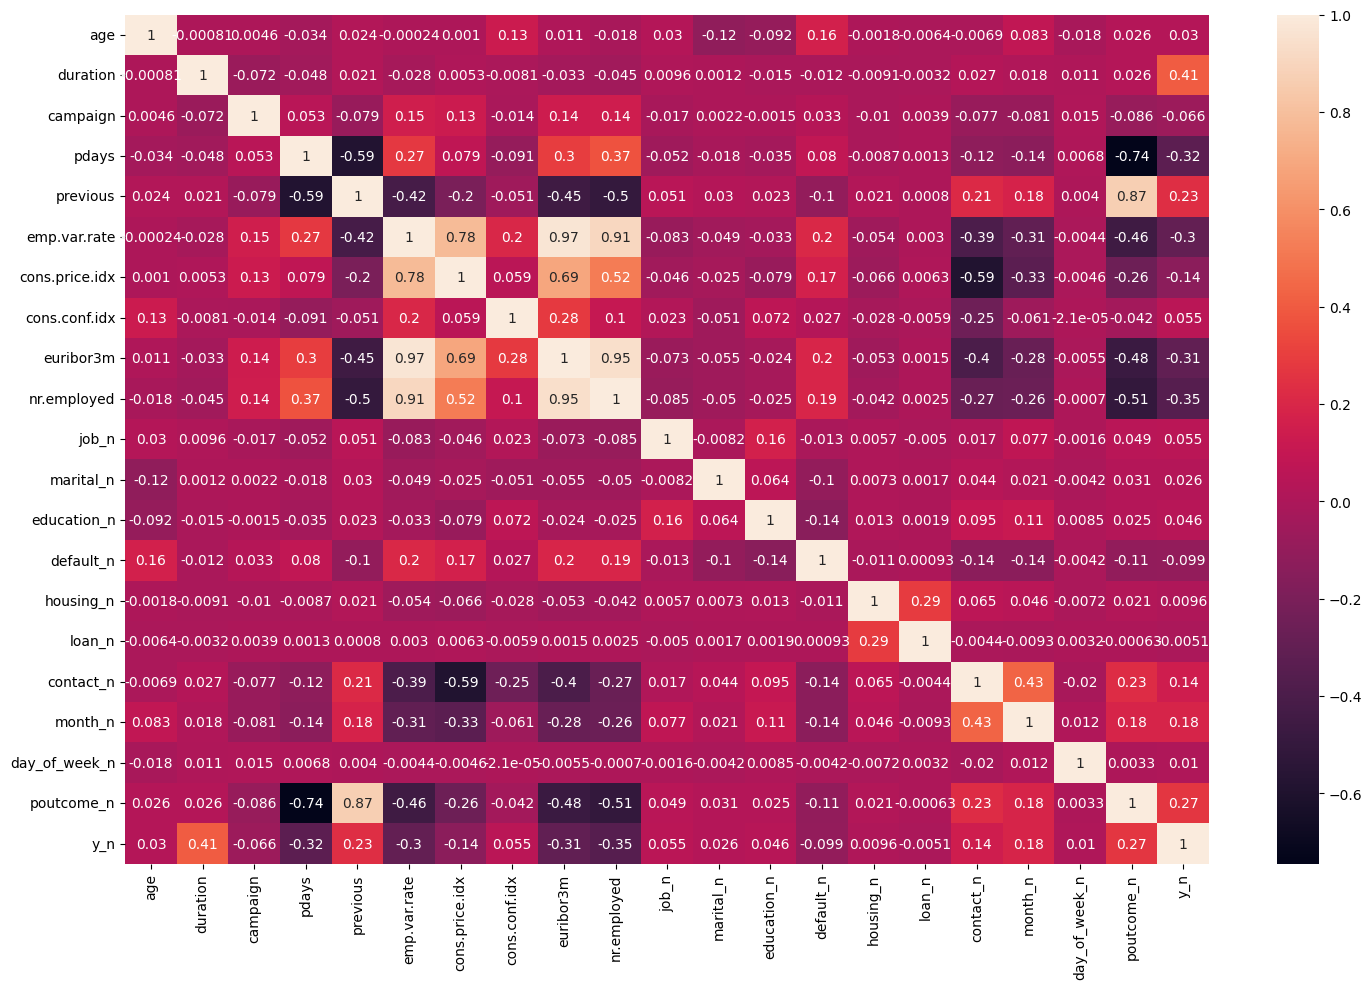

In [12]:
plt.figure(figsize=(15, 10))

sns.heatmap(datos[["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed","job_n", "marital_n", "education_n", "default_n", "housing_n", "loan_n", "contact_n", "month_n", "day_of_week_n", "poutcome_n", "y_n"]].corr(), annot=True)

plt.tight_layout()
plt.show()

#Como podemos ver en el mapa de calor, no tenemos relaciones muy significativas

In [16]:
# Suponiendo que la columna 'y_n' es tu variable objetivo
X = datos_finales.drop('y_n', axis=1)
y = datos_finales['y_n']

# Crear el modelo de Bosques Aleatorios
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Obtener importancia de características
importancias = clf.feature_importances_

# Crear un DataFrame para visualizar las importancias
df_importancia = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': importancias
})

# Ordenar el DataFrame por importancia
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

# Visualizar la importancia de características con un gráfico de barras
plt.figure(figsize=(15, 10))
sns.barplot(x='Importancia', y='Característica', data=df_importancia)
plt.title('Importancia de Características con Bosques Aleatorios')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

NameError: name 'datos_nueva' is not defined

In [ ]:
datos_finales = datos_finales.corr()
datos_finales.style.background_gradient(cmap='coolwarm').format(precision=3)

,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_n
job_n,1.000,-0.008,0.165,-0.013,0.006,-0.005,0.017,0.077,-0.002,0.049,0.030,0.010,-0.017,-0.052,0.051,-0.083,-0.046,0.023,-0.073,-0.085,0.055
marital_n,-0.008,1.000,0.064,-0.104,0.007,0.002,0.044,0.021,-0.004,0.031,-0.115,0.001,0.002,-0.018,0.030,-0.049,-0.025,-0.051,-0.055,-0.050,0.026
education_n,0.165,0.064,1.000,-0.144,0.013,0.002,0.095,0.115,0.008,0.025,-0.092,-0.015,-0.002,-0.035,0.023,-0.033,-0.079,0.072,-0.024,-0.025,0.046
default_n,-0.013,-0.104,-0.144,1.000,-0.011,0.001,-0.135,-0.136,-0.004,-0.108,0.165,-0.012,0.033,0.080,-0.102,0.203,0.168,0.027,0.195,0.190,-0.099
housing_n,0.006,0.007,0.013,-0.011,1.000,0.290,0.065,0.046,-0.007,0.021,-0.002,-0.009,-0.010,-0.009,0.021,-0.054,-0.066,-0.028,-0.053,-0.042,0.010
loan_n,-0.005,0.002,0.002,0.001,0.290,1.000,-0.004,-0.009,0.003,-0.001,-0.006,-0.003,0.004,0.001,0.001,0.003,0.006,-0.006,0.002,0.002,-0.005
contact_n,0.017,0.044,0.095,-0.135,0.065,-0.004,1.000,0.431,-0.020,0.227,-0.007,0.027,-0.077,-0.118,0.213,-0.394,-0.592,-0.252,-0.400,-0.269,0.145
month_n,0.077,0.021,0.115,-0.136,0.046,-0.009,0.431,1.000,0.012,0.185,0.083,0.018,-0.081,-0.135,0.176,-0.306,-0.331,-0.061,-0.276,-0.262,0.184
day_of_week_n,-0.002,-0.004,0.008,-0.004,-0.007,0.003,-0.020,0.012,1.000,0.003,-0.018,0.011,0.015,0.007,0.004,-0.004,-0.005,-0.000,-0.006,-0.001,0.010
poutcome_n,0.049,0.031,0.025,-0.108,0.021,-0.001,0.227,0.185,0.003,1.000,0.026,0.026,-0.086,-0.745,0.869,-0.457,-0.260,-0.042,-0.479,-0.510,0.270


In [ ]:
# Dividir el conjunto de datos en subconjuntos de entrenamiento y prueba.
# El 80% de los datos se utiliza para entrenamiento y el 20% para pruebas.
# random_state=42 garantiza que el proceso de división sea reproducible.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo SelectKBest con el criterio chi2 para la selección de características.
# Se seleccionarán las 5 mejores características basadas en el test de chi-cuadrado.
seleccion_modelo = SelectKBest(chi2, k=5)

# Ajustar el modelo de selección de características usando los datos de entrenamiento.
# Esto evalúa qué características tienen la mayor relevancia estadística (según chi2) con respecto a la variable objetivo.
seleccion_modelo.fit(X_train, y_train)

# Obtener un arreglo booleano que indica qué características (columnas) fueron seleccionadas como las mejores.
# Por ejemplo, si el conjunto de datos original tiene 10 características y solo 5 fueron seleccionadas,
# este arreglo podría lucir así: [True, True, False, True, False, True, False, False, False, False]
id = seleccion_modelo.get_support()

# Transformar el conjunto de datos de entrenamiento para quedarnos solo con las columnas seleccionadas.
# Las columnas no seleccionadas se eliminan del conjunto de entrenamiento.
seleccion_x_entrenado = pd.DataFrame(seleccion_modelo.transform(X_train), columns=X_train.columns.values[id])

# Realizar la misma transformación en el conjunto de datos de prueba.
# Aquí también nos quedamos solo con las columnas seleccionadas.
seleccion_x_testeo = pd.DataFrame(seleccion_modelo.transform(X_test), columns=X_test.columns.values[id])


In [ ]:
seleccion_x_entrenado.head()

,month_n,poutcome_n,emp.var.rate,euribor3m,nr.employed
0,2.0,0.0,1.000000,0.980503,1.000000
1,1.0,0.0,1.000000,0.958966,1.000000
2,3.0,0.0,1.000000,0.981410,1.000000
3,0.0,0.0,0.937500,0.958059,0.859735
4,0.0,0.0,0.333333,0.148946,0.512287


In [ ]:
seleccion_x_testeo.head()

,month_n,poutcome_n,emp.var.rate,euribor3m,nr.employed
0,1.0,0.0,0.104167,0.143278,0.425709
1,0.0,1.0,0.333333,0.150759,0.512287
2,4.0,0.0,0.479167,0.073679,0.000000
3,0.0,1.0,0.333333,0.150759,0.512287
4,2.0,0.0,1.000000,0.981410,1.000000


In [ ]:
# Cargar los datos de entrenamiento y prueba desde archivos CSV
datos_entrenados = pd.read_csv('/workspaces/primer-algoritmo/src/xentrenado.csv')
datos_testeo = pd.read_csv('/workspaces/primer-algoritmo/src/xtesteo.csv')

# Preparar las características y etiquetas para el conjunto de entrenamiento
# 'drop' elimina la columna 'y_n', dejando sólo las características en X_train
X_train = datos_entrenados.drop(['y_n'], axis=1)
# 'y_n' es la columna de etiquetas o resultados para el conjunto de entrenamiento
y_train = datos_entrenados['y_n']

# Preparar las características y etiquetas para el conjunto de prueba
X_test = datos_testeo.drop(['y_n'], axis=1)
y_test = datos_testeo['y_n']

# Crear un modelo de Regresión Logística
modelo = LogisticRegression()
# Entrenar el modelo utilizando el conjunto de entrenamiento
modelo.fit(X_train, y_train)

# Usar el modelo entrenado para predecir etiquetas para el conjunto de prueba
prediccion_y = modelo.predict(X_test)

# Comparar las predicciones del modelo con las etiquetas reales del conjunto de prueba
# y calcular la precisión del modelo
precisión = accuracy_score(y_test, prediccion_y)

print(f"Precisión del modelo: {precisión * 100:.2f}%")

Precisión del modelo: 88.84%


In [ ]:
# Importamos la herramienta GridSearchCV del módulo de selección de modelos.
from sklearn.model_selection import GridSearchCV

# Definimos los hiperparámetros que queremos ajustar. 
# Estos hiperparámetros son específicos para el modelo de Regresión Logística.
# - C: Es el inverso de la regularización. Valores pequeños especifican una regularización más fuerte.
# - penalty: Especifica la norma utilizada en la penalización (l1, l2, etc.).
# - solver: Algoritmo a usar en el problema de optimización.
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    "penalty": ["l1", "l2", "elasticnet", None], 
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

# Inicializamos el GridSearchCV.
# - modelo es la instancia del modelo que queremos entrenar.
# - hyperparams es el grid de hiperparámetros que definimos arriba.
# - scoring = "accuracy" indica que queremos optimizar la precisión del modelo.
# - cv = 10 indica que se utilizará validación cruzada de 10 pliegues.
grid = GridSearchCV(modelo, hyperparams, scoring="accuracy", cv=10)

# Hasta este punto, simplemente hemos creado un objeto `grid`. 
# Para realizar realmente la búsqueda de hiperparámetros, debes llamar a grid.fit(X, y).
# Después de entrenar, puedes usar grid.best_params_ para ver los mejores hiperparámetros encontrados.

grid

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [ ]:
# Ejecutamos la búsqueda de hiperparámetros usando la validación cruzada sobre el conjunto de entrenamiento.
# Esto puede tardar un tiempo, ya que prueba todas las combinaciones posibles de hiperparámetros y realiza
# una validación cruzada de 10 pliegues para cada combinación.
grid.fit(X_train, y_train)

# Una vez finalizada la búsqueda, imprimimos los mejores hiperparámetros encontrados.
# Estos hiperparámetros son los que dieron la mejor precisión (accuracy) promedio durante la validación cruzada.
print(f"Best hyperparameters: {grid.best_params_}")

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: U

Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
modelo = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'newton-cg')
modelo.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='newton-cg')

In [ ]:
prediccion_y = modelo.predict(X_test)
prediccion_y

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
accuracy_score(prediccion_y,y_test)

0.8895094706168043

In [ ]:
from sklearn.preprocessing import StandardScaler

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print(f"Accuracy con Random Forest: {accuracy_score(y_test, y_pred_rf)}")

Accuracy con Random Forest: 0.8920592520641087


In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(rf_model, param_grid_rf, scoring="accuracy", cv=5)
grid_rf.fit(X_train_scaled, y_train)

print(f"Mejores hiperparámetros para Random Forest: {grid_rf.best_params_}")


Mejores hiperparámetros para Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)
print(f"Accuracy con Random Forest optimizado: {accuracy_score(y_test, y_pred_best_rf)}")


Accuracy con Random Forest optimizado: 0.8946090335114133
